# День 1. 02-22

Пока скачиваются зависимости для RepeatModeller-a (а конкретно RMBlast), начну неопцианальные шаги с готовыми данными.

Скачал augustus.whole.gff

Достать белок-кодирующие последовательности:

```bash
bash get-fasta.sh data/augustus.whole.gff
```

https://github.com/tejashree1modak/AUGUSTUS-helpers

```bash
grep -c ">" protein.fasta 

out: 16435
```

### Local blast search:

```bash
makeblastdb -in protein.fasta -blastdb_version 5 -dbtype prot
blastp -db protein.fasta -query ./data/peptides.fa -out blast-results.out
```

upd. формат по умолчанию какой-то странный
```bash
blastp -db protein.fasta -query ./data/peptides.fa -out blast-results.out -outfmt "7 qacc sacc evalue qstart qend sstart send"

cut -f2 blast-results.out | grep -v "#" | sort | uniq > protein_names.txt  # -v for invert matching
```

In [19]:
df = pd.read_csv('blast-results.out', sep='\t', comment='#', header=None)
s = 'qacc sacc evalue qstart qend sstart send'
df.columns = s.split(' ')
df.sort_values(by='evalue')

,qacc,sacc,evalue,qstart,qend,sstart,send
48,pept_21_score_73,G12510,1.490000e-09,1,22,443,464
45,pept_20_score_113,G12510,3.470000e-07,1,18,425,442
84,pept_29_score_95,g4106,2.000000e-06,1,18,222,239
15,pept_8_score_81,g4106,2.000000e-06,1,18,222,239
98,pept_34_score_54,G15484,9.590000e-06,1,18,755,772
...,...,...,...,...,...,...,...
115,pept_41_score_49,G11513,8.300000e+00,2,9,872,879
102,pept_37_score_41,g2203,8.400000e+00,1,9,359,367
86,pept_29_score_95,g4970,8.800000e+00,5,18,134,147
17,pept_8_score_81,g4970,8.800000e+00,5,18,134,147


При попытке сделать 
```bash
xargs samtools faidx proteins.fasta < protein_names.txt
```
...обнаружилось, что тех последовательностей, которые начинаются с большой буквы G, нет в файле proteins.fasta

Поэтому:
```bash
cut -f2 blast-results.out | grep -v "#" | grep "G" | sort | uniq > capital_protein_names.txt  # вдруг пригодятся
cut -f2 blast-results.out | grep -v "#" | -v grep "G" | sort | uniq > protein_names.txt
xargs samtools faidx protein.fasta < protein_names.txt > lowercase_aligned_proteins.fasta
```

### Localization prediction

#### 1. WoLF PSORT

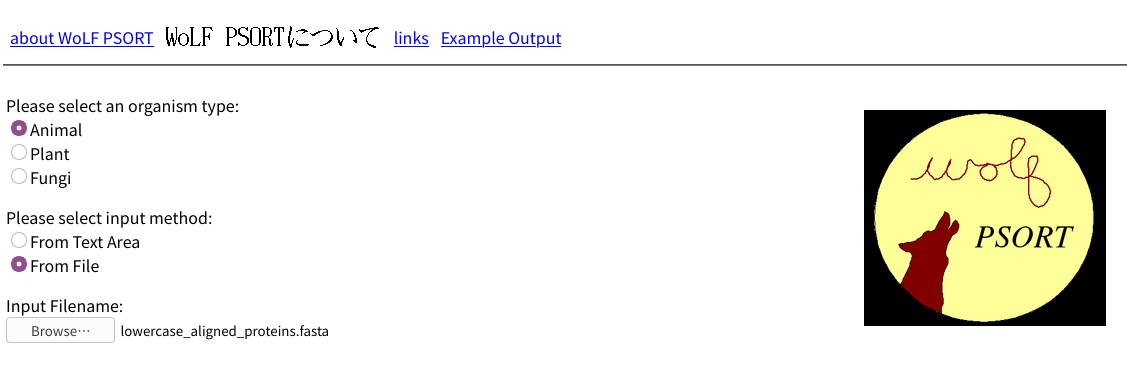

results: https://wolfpsort.hgc.jp/results/aKGfc26b3f653936ebd93c7a8e6bab92375.html

#### 2. TargetP 1.1 Server

http://www.cbs.dtu.dk/cgi-bin/webface2.fcgi?jobid=6033FA57000064FEC6D4090B&wait=20

### Blast search

search:

https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Web&PAGE_TYPE=BlastSearch&VIEW_SEARCH=on&UNIQ_SEARCH_NAME=A_SearchOptions_1lEGnm_1A2q_dtkQfpbc45O_GTXQl_LxguJ

In [206]:
s = ('query acc.ver, subject acc.ver, % identity, alignment length, mismatches, gap opens, '
     'q. start, q. end, s. start, s. end, evalue, bit score, % positives')

df = pd.read_csv('38321Z1Y016-Alignment-HitTable.csv', header=None)
df.columns = s.split(', ')
df = df[['query acc.ver', 'subject acc.ver', '% identity', 'evalue']]
proteins = df['query acc.ver'].unique()

from IPython.display import display
tmp = {}
for protein in proteins:
    ev = df[df['query acc.ver'] == protein]['evalue'].min()
    tmp[protein] = ev
    
s = 'query acc.ver, subject acc.ver, % identity, evalue'
best_hits = pd.DataFrame(columns=s.split(', '))
for prot, ev in tmp.items():
    best_hits = best_hits.append(df[(df['query acc.ver'] == prot) & (df['evalue'] == tmp[prot])].iloc[0])

best_hits.reset_index(inplace=True)
best_hits.drop(columns=['index'], inplace=True)
    
# не нашёл, как можно скачать по-нормальному вместе со значением Query Cover...

# не выравнялись:
unaligned = [4106, 5237, 5443, 5510]

query_cover = [ 
    44, 
    75, 
    91,
    72,
    46,
    46,
    33,
    38,
    40,
    43,
    14,
    39,
    99,
    22,
    84
]
best_hits['query cover'] = query_cover
for ua in unaligned:
    tmp = {
        'query acc.ver': 'g' + str(ua), 'subject acc.ver': None, '% identity': None, 'evalue': None,
        'query cover': None
    }
    best_hits = best_hits.append(tmp, ignore_index=True)

best_hits.rename(columns={'query acc.ver': 'protein'}, inplace=True)
best_hits.set_index('protein', inplace=True)
best_hits

,subject acc.ver,% identity,evalue,query cover
protein,,,,
g1285,P0DPW4.1,37.209,1.740000e-12,44
g2203,Q69ZQ1.2,35.925,2.380000e-126,75
g3428,Q09510.1,56.604,8.530000e-65,91
g3679,Q19269.2,29.717,7.240000e-22,72
g4970,P97435.1,25.342,3.990000e-16,46
g5467,P0DPW4.1,44.118,3.810000e-13,46
g5502,P0DPW4.1,39.759,5.670000e-14,33
g5503,P0DPW4.1,39.759,6.560000e-14,38
g5616,P0DPW4.1,40.964,2.190000e-14,40


### Pfam

In [214]:
s = """1 	g1285 	1 	DONE 	CBM_14 	Chitin binding Peritrophin-A domain 	show
2 	g2203 	1 	DONE 	Glyco_hydro_31 	Glycosyl hydrolases family 31 	show
3 	g3428 	0 	DONE 			show
4 	g3679 	1 	DONE 	Astacin 	Astacin (Peptidase family M12A) 	show
5 	g4106 	0 	DONE 			show
6 	g4970 	3 	DONE 	Trypsin 	Trypsin 	show
7 	g5237 	0 	DONE 			show
8 	g5443 	0 	DONE 			show
9 	g5467 	1 	DONE 	CBM_14 	Chitin binding Peritrophin-A domain 	show
10 	g5502 	1 	DONE 	CBM_14 	Chitin binding Peritrophin-A domain 	show
11 	g5503 	1 	DONE 	CBM_14 	Chitin binding Peritrophin-A domain 	show
12 	g5510 	1 	DONE 	MARVEL 	Membrane-associating domain 	show
13 	g5616 	1 	DONE 	CBM_14 	Chitin binding Peritrophin-A domain 	show
14 	g5641 	1 	DONE 	CBM_14 	Chitin binding Peritrophin-A domain 	show
15 	g5927 	0 	DONE 			show
16 	g702 	1 	DONE 	CBM_14 	Chitin binding Peritrophin-A domain 	show
17 	g7861 	3 	DONE 	SNF2_N 	SNF2 family N-terminal domain 	show
18 	g8100 	2 	DONE 	Inositol_P 	Inositol monophosphatase family 	show
19 	g8312 	1 	DONE 	Clathrin 	Region in Clathrin and VPS 	show"""
pfam = pd.DataFrame([line.split('\t') for line in s.splitlines()])
pfam = pfam.drop(columns=[2, 3, 6, 0])
pfam[1] = pfam[1].apply(lambda x: x.strip())
pfam.columns = ['protein', 'identifier', 'description']
pfam.set_index('protein', inplace=True)

best_hits['Pfam identifier'] = pfam['identifier']
best_hits['Pfam description'] = pfam['description']
best_hits

,subject acc.ver,% identity,evalue,query cover,Pfam identifier,Pfam description,wolf_localization
protein,,,,,,,
g1285,P0DPW4.1,37.209,1.740000e-12,44,CBM_14,Chitin binding Peritrophin-A domain,extr
g2203,Q69ZQ1.2,35.925,2.380000e-126,75,Glyco_hydro_31,Glycosyl hydrolases family 31,plas
g3428,Q09510.1,56.604,8.530000e-65,91,,,mito cyto
g3679,Q19269.2,29.717,7.240000e-22,72,Astacin,Astacin (Peptidase family M12A),extr
g4970,P97435.1,25.342,3.990000e-16,46,Trypsin,Trypsin,plas
g5467,P0DPW4.1,44.118,3.810000e-13,46,CBM_14,Chitin binding Peritrophin-A domain,extr
g5502,P0DPW4.1,39.759,5.670000e-14,33,CBM_14,Chitin binding Peritrophin-A domain,extr
g5503,P0DPW4.1,39.759,6.560000e-14,38,CBM_14,Chitin binding Peritrophin-A domain,extr
g5616,P0DPW4.1,40.964,2.190000e-14,40,CBM_14,Chitin binding Peritrophin-A domain,extr


### wolf

In [213]:
s = """g1285 details extr: 25, plas: 5, mito: 1, lyso: 1
g2203 details plas: 29, nucl: 2, golg: 1
g3428 details mito: 18, cyto: 11, extr: 2, nucl: 1
g3679 details extr: 26, mito: 2, lyso: 2, plas: 1, E.R.: 1
g4106 details E.R.: 14.5, E.R._golg: 9.5, extr: 7, golg: 3.5, lyso: 3, pero: 2, plas: 1, mito: 1
g4970 details plas: 32
g5237 details plas: 24, mito: 8
g5443 details extr: 28, nucl: 3, cyto: 1
g5467 details extr: 27, plas: 4, mito: 1
g5502 details extr: 31, lyso: 1
g5503 details extr: 29, plas: 1, mito: 1, lyso: 1
g5510 details plas: 23, mito: 7, E.R.: 1, golg: 1
g5616 details extr: 31, mito: 1
g5641 details extr: 31, lyso: 1
g5927 details nucl: 30.5, cyto_nucl: 16.5, cyto: 1.5
g702 details extr: 29, plas: 2, lyso: 1
g7861 details nucl: 16, cyto_nucl: 14, cyto: 8, plas: 5, pero: 1, cysk: 1, golg: 1
g8100 details nucl: 16.5, cyto_nucl: 12.5, cyto: 7.5, plas: 5, extr: 2, E.R.: 1
g8312 details nucl: 15.5, cyto_nucl: 15.5, cyto: 12.5, mito: 2, plas: 1, golg: 1"""

# lets consider significant clusters which provide at least 10 neighbors
lst = []
for line in s.splitlines():
    tmp = line.split()
    idx = tmp[0]
    values = tmp[2:]
    
    significant = []
    for i in range(0, len(values), 2):
        v = ''.join(ch for ch in values[i+1] if ch != ',')
        if float(v) >= 10:
            significant.append(values[i][:-1])
    lst.append([idx, ' '.join(significant)])
    
wolf = pd.DataFrame(lst)
wolf.columns = ['protein', 'localization']
wolf.set_index('protein', inplace=True)

best_hits['wolf_localization'] = wolf['localization']
best_hits

,subject acc.ver,% identity,evalue,query cover,Pfam identifier,Pfam description,wolf_localization
protein,,,,,,,
g1285,P0DPW4.1,37.209,1.740000e-12,44,CBM_14,Chitin binding Peritrophin-A domain,extr
g2203,Q69ZQ1.2,35.925,2.380000e-126,75,Glyco_hydro_31,Glycosyl hydrolases family 31,plas
g3428,Q09510.1,56.604,8.530000e-65,91,,,mito cyto
g3679,Q19269.2,29.717,7.240000e-22,72,Astacin,Astacin (Peptidase family M12A),extr
g4970,P97435.1,25.342,3.990000e-16,46,Trypsin,Trypsin,plas
g5467,P0DPW4.1,44.118,3.810000e-13,46,CBM_14,Chitin binding Peritrophin-A domain,extr
g5502,P0DPW4.1,39.759,5.670000e-14,33,CBM_14,Chitin binding Peritrophin-A domain,extr
g5503,P0DPW4.1,39.759,6.560000e-14,38,CBM_14,Chitin binding Peritrophin-A domain,extr
g5616,P0DPW4.1,40.964,2.190000e-14,40,CBM_14,Chitin binding Peritrophin-A domain,extr


### TargetP

In [222]:
s="""g1285	SP	0.003029	0.996798	0.000173	CS pos: 16-17. ASA-TS. Pr: 0.7127
g2203	OTHER	0.999869	0.000031	0.000100	
g3428	OTHER	0.999903	0.000033	0.000064	
g3679	SP	0.001755	0.998023	0.000222	CS pos: 18-19. TFA-AR. Pr: 0.5523
g4106	OTHER	0.729658	0.266917	0.003425	
g4970	OTHER	0.999996	0.000003	0.000001	
g5237	OTHER	0.999545	0.000345	0.000111	
g5443	OTHER	0.952853	0.043784	0.003363	
g5467	SP	0.000096	0.999845	0.000059	CS pos: 16-17. ASA-GS. Pr: 0.6543
g5502	SP	0.001134	0.998823	0.000043	CS pos: 16-17. ASA-GS. Pr: 0.6833
g5503	SP	0.001222	0.998720	0.000058	CS pos: 16-17. ASA-GS. Pr: 0.6833
g5510	OTHER	0.999108	0.000016	0.000876	
g5616	SP	0.000067	0.999933	0.000000	CS pos: 16-17. ACA-AN. Pr: 0.5270
g5641	SP	0.000130	0.999869	0.000001	CS pos: 16-17. ACA-AS. Pr: 0.4873
g5927	OTHER	0.999995	0.000001	0.000004	
g702	SP	0.000347	0.999652	0.000001	CS pos: 16-17. ALA-AN. Pr: 0.8153
g7861	OTHER	0.999975	0.000004	0.000022	
g8100	OTHER	0.999955	0.000024	0.000021	
g8312	OTHER	0.999930	0.000065	0.000004"""	
target = pd.DataFrame([line.split('\t') for line in s.splitlines()])
target = target.iloc[:, :2]
target.set_index(0, inplace=True)

best_hits['Target prediction'] = target[1]
best_hits

,subject acc.ver,% identity,evalue,query cover,Pfam identifier,Pfam description,wolf_localization,Target prediction
protein,,,,,,,,
g1285,P0DPW4.1,37.209,1.740000e-12,44,CBM_14,Chitin binding Peritrophin-A domain,extr,SP
g2203,Q69ZQ1.2,35.925,2.380000e-126,75,Glyco_hydro_31,Glycosyl hydrolases family 31,plas,OTHER
g3428,Q09510.1,56.604,8.530000e-65,91,,,mito cyto,OTHER
g3679,Q19269.2,29.717,7.240000e-22,72,Astacin,Astacin (Peptidase family M12A),extr,SP
g4970,P97435.1,25.342,3.990000e-16,46,Trypsin,Trypsin,plas,OTHER
g5467,P0DPW4.1,44.118,3.810000e-13,46,CBM_14,Chitin binding Peritrophin-A domain,extr,SP
g5502,P0DPW4.1,39.759,5.670000e-14,33,CBM_14,Chitin binding Peritrophin-A domain,extr,SP
g5503,P0DPW4.1,39.759,6.560000e-14,38,CBM_14,Chitin binding Peritrophin-A domain,extr,SP
g5616,P0DPW4.1,40.964,2.190000e-14,40,CBM_14,Chitin binding Peritrophin-A domain,extr,SP
